In [1]:
import os, copy
import math, random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F


from datetime import datetime
from collections import deque
from IPython.display import clear_output
import matplotlib.pyplot as plt


USE_CUDA = torch.cuda.is_available()
#쿠다 사용시 RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same 애러
USE_CUDA = False
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args,
                                                                                                                **kwargs)


In [2]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)
    
    def change_last_done(self):
        last = list(self.buffer[-1])
        last[4] = True
        self.buffer.pop()
        self.buffer.append(last)
        
    def get_last(self):
        return self.buffer[-1]

In [3]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()

        self.input_shape = input_shape  # 8*8 state(observation) size
        self.num_actions = num_actions  # 8*8 action size 난 똑같

        self.features = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, stride=1),
            # output는 6*6
            nn.ReLU(),
        )

        # fully connected = 그냥 신경망
        self.fc = nn.Sequential(
            nn.Linear(32*6*6, 24),
            nn.ReLU(),
            nn.Linear(24, self.num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(32,1, *self.input_shape))).view(1, -1).size(1)

    def act(self, state, epsilon, validlist):
        if random.random() > epsilon:
            state = np.expand_dims(np.float32(state), 0)
            state = Variable(torch.FloatTensor(state), volatile=True)
            
            q_value = self.forward(state)  # size 64의 linear [1,2,3,4]
            # q_value에서 valid 한 것만 놔두기.
            valid_q_value = []
#             print(q_value)
            for i in validlist:
                idx = i[0]*8 + i[1]
                valid_q_value.append(q_value[0, idx])
                
            # action = valid_q_value.max(1)[1].data[0]
            val = np.max(valid_q_value)
            val_idx = (q_value[0] == val).nonzero().item()
            # 해당 인덱스의 좌표 찾기
            x = int(val_idx//8)
            y = int(val_idx % 8)
            action = (x, y)

        else:
            random.shuffle(validlist)
            (x, y) = validlist.pop()
            x = int(x)
            y = int(y)
            action = (x, y)

        return action


In [4]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    
    action_list = []
    for i in range(32):
        action_idx = action[i][0]*8 + action[i][1]
        action_list.append(action_idx)
        
    action = Variable(torch.LongTensor(action_list))
    reward = Variable(torch.FloatTensor(reward))
    done = Variable(torch.FloatTensor(done))

    q_values = model(state)
    next_q_values = model(next_state)

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss


def plot(frame_idx, mean_rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, mean_rewards[-1:]))
    plt.plot(mean_rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()


def InitBoard():
    if n % 2 == 0:  # if board size is even
        z = int((n - 2) / 2)
        board[z][z] = '-1'
        board[n - 1 - z][z] = '1'
        board[z][n - 1 - z] = '1'
        board[n - 1 - z][n - 1 - z] = '-1'


def PrintBoard():
    m = len(str(n - 1))
    for y in range(n):
        row = ''
        for x in range(n):
            row += board[y][x]
            row += ' ' * m
        print(row + ' ' + str(y))
    print
    row = ''
    for x in range(n):
        row += str(x).zfill(m) + ' '
    print(row + '\n')


def MakeMove(board, x, y, player):  # assuming valid move
    totctr = 0  # total number of opponent pieces taken
    board[y][x] = player
    for d in range(8):  # 8 directions
        ctr = 0
        for i in range(n):
            dx = x + dirx[d] * (i + 1)
            dy = y + diry[d] * (i + 1)
            if dx < 0 or dx > n - 1 or dy < 0 or dy > n - 1:
                ctr = 0;
                break
            elif board[dy][dx] == player:
                break
            elif board[dy][dx] == '0':
                ctr = 0;
                break
            else:
                ctr += 1
        for i in range(ctr):
            dx = x + dirx[d] * (i + 1)
            dy = y + diry[d] * (i + 1)
            board[dy][dx] = player
        totctr += ctr
    return (board, totctr)


def ValidMove(board, x, y, player):
    if x < 0 or x > n - 1 or y < 0 or y > n - 1:
        return False
    if board[y][x] != '0':
        return False
    (boardTemp, totctr) = MakeMove(copy.deepcopy(board), x, y, player)
    if totctr == 0:
        return False
    return True

def EvalBoard(board, player):
    tot = 0
    for y in range(n):
        for x in range(n):
            if board[y][x] == player:
                tot += 1
    return tot

def IsTerminalNode(board, player):
    for y in range(n):
        for x in range(n):
            if ValidMove(board, x, y, player):
                return False
    return True

def BestMove(board, player):
    maxPoints = 0
    mx = -1;
    my = -1
    for y in range(n):
        for x in range(n):
            if ValidMove(board, x, y, player):
                (boardTemp, totctr) = MakeMove(copy.deepcopy(board), x, y, player)
                points = AlphaBeta(board, player, depth, minEvalBoard, maxEvalBoard, True)
                if points > maxPoints:
                    maxPoints = points
                    mx = x;
                    my = y
    return (mx, my)


def AlphaBeta(board, player, depth, alpha, beta, maximizingPlayer):
    if depth == 0 or IsTerminalNode(board, player):
        return EvalBoard(board, player)
    if maximizingPlayer:
        v = minEvalBoard
        for y in range(n):
            for x in range(n):
                if ValidMove(board, x, y, player):
                    (boardTemp, totctr) = MakeMove(copy.deepcopy(board), x, y, player)
                    v = max(v, AlphaBeta(boardTemp, player, depth - 1, alpha, beta, False))
                    alpha = max(alpha, v)
                    if beta <= alpha:
                        break  # beta cut-off
        return v
    else:  # minimizingPlayer
        v = maxEvalBoard
        for y in range(n):
            for x in range(n):
                if ValidMove(board, x, y, player):
                    (boardTemp, totctr) = MakeMove(copy.deepcopy(board), x, y, player)
                    v = min(v, AlphaBeta(boardTemp, player, depth - 1, alpha, beta, True))
                    beta = min(beta, v)
                    if beta <= alpha:
                        break  # alpha cut-off
        return v


def GetSortedNodes(board, player):
    sortedNodes = []
    for y in range(n):
        for x in range(n):
            if ValidMove(board, x, y, player):
                (boardTemp, totctr) = MakeMove(copy.deepcopy(board), x, y, player)
                sortedNodes.append((boardTemp, EvalBoard(boardTemp, player)))
    sortedNodes = sorted(sortedNodes, key=lambda node: node[1], reverse=True)
    sortedNodes = [node[0] for node in sortedNodes]
    return sortedNodes


def get_validlist(board, player):
    validlist = []
    for x in range(8):
        for y in range(8):
            if ValidMove(board, x, y, player):
                validlist.append([x, y])
    return validlist


def random_agent(board, player):
    validlist = get_validlist(board, player)
    random.shuffle(validlist)
    (x, y) = validlist.pop()
    x = int(x)
    y = int(y)
    (board, totctr) = MakeMove(board, x, y, player)
#     print('player' + player + 'played (X Y): ' + str(x) + ' ' + str(y))
#     print('# of pieces taken: ' + str(totctr))
#     PrintBoard()


def alphabeta_agent(board, player):
    (x, y) = BestMove(board, player)
    if not (x == -1 and y == -1):
        (board, totctr) = MakeMove(board, x, y, player)
        print('AlphaBeta played (X Y): ' + str(x) + ' ' + str(y))
        print('# of pieces taken: ' + str(totctr))

# Random VS DQN

In [ ]:
#model = CnnDQN((8, 8), 8 * 8)
model = torch.load('../save/20181216_023330.pt')

optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_initial = 300
replay_buffer = ReplayBuffer(10000)

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 10000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(
    -1. * frame_idx / epsilon_decay)

n = 8  # board size (even)

board = [['0' for x in range(n)] for y in range(n)]
# 8 directions
dirx = [-1, 0, 1, -1, 1, -1, 0, 1]
diry = [-1, -1, -1, 0, 0, 1, 1, 1]

opt = 2
depth = 4

num_frames = 14000
batch_size = 32
gamma = 0.99

losses = []
all_rewards = []
episode_reward = 0

minEvalBoard = -1  # min - 1
maxEvalBoard = n * n + 4 * n + 4 + 1  # max + 1

all_rewards = []
mean_rewards = []
state_save = []
num_episode = 100
terminal = False
for i in range(num_episode):
    
    # for frame_idx in range(1, num_frames+1):
    state = [['0' for x in range(n)] for y in range(n)]
    board = [['0' for x in range(n)] for y in range(n)]
    InitBoard()
    terminal = False
    print(i+1,"번째 게임")
#     PrintBoard()
    # 한 게임

    while not terminal:
        for p in range(2):
            print
            if p == 0:
                player = str(p+1)
            else:
                player = '-1'
#             print('PLAYER: ' + player)

            if player == '1':  # computer1's turn
                
                if IsTerminalNode(board, player):
                    terminal = True
                else:
                    terminal = False
                    random_agent(board, player)

            else:  # computer2's turn (학습시킬아이) -1
                if IsTerminalNode(board, player):
                    terminal = True
                else:
                    terminal = False
                    if (EvalBoard(board, '1') + EvalBoard(board, '-1') == 5): # 첫수 둘때
                        state = copy.deepcopy(board)
                        state = np.expand_dims(state, 0)
                        state = np.concatenate((state, state,state,state),axis=0)
                        state_save.append(state)
                        
                    else: # 첫 수 이후
                        state = copy.deepcopy(board)
                        state_save[-1][-1] = state
                        state = state_save[-1]

                    epsilon = epsilon_by_frame(i)
                    validlist = get_validlist(board, player)
                    action = model.act(state, epsilon, validlist)  # return (x,y)
                    x = action[0]
                    y = action[1]

                    (board, totctr) = MakeMove(board, x, y, player)
                    # terminal 체크

                    next_state = copy.deepcopy(board)
                    next_state = np.expand_dims(next_state, 0)
                    next_state = np.concatenate((next_state, next_state, next_state, next_state),axis=0)
                    next_state, reward, done = next_state, 0, terminal
                    
                    # 이걸 리스트에 다 넣고
                    replay_buffer.push(state, action, reward, next_state, done)


#                     print('player' + player + 'played (X Y): ' + str(x) + ' ' + str(y))
#                     print('# of pieces taken: ' + str(totctr))
#                     PrintBoard()

    # 한 게임이 끝났을 때
    # 에피소드 list의 마지막 done을 True로 바꾸고 그걸 buffer로 바꾸기
    replay_buffer.change_last_done()
    print('게임종료')
    PrintBoard()
    print('Score Comp1: ' + str(EvalBoard(board, '1')))
    print('Score Comp2: ' + str(EvalBoard(board, '-1')))
    print("")
    
    if EvalBoard(board, '-1') > EvalBoard(board, '1'):
        reward = 1
    elif EvalBoard(board, '-1') == EvalBoard(board, '1'):
        reward = 0
    else:
        reward = -1
        
    all_rewards.append(reward)
    reward = 0
    
    if len(replay_buffer) > replay_initial:
        if num_episode % 10 == 0:
            loss = compute_td_loss(batch_size)
            losses.append(loss.item())
            
    if i % 10 == 0:
        mean_rewards.append(np.mean(all_rewards[-10:]))
        plot(i, mean_rewards, losses)
#         now = datetime.today().strftime("%Y%m%d_%H%M%S")
        #torch.save(model, "../save/"+now+".pt")

# AlphaBeta VS DQN

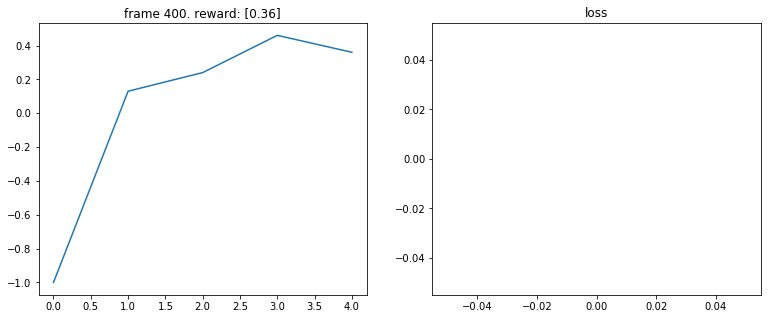

402 번째 게임
게임종료
1 1 1 1 1 1 -1 -1  0
1 1 1 1 1 1 -1 -1  1
1 -1 -1 1 1 1 -1 -1  2
1 -1 1 -1 -1 1 -1 -1  3
1 1 -1 -1 1 1 -1 -1  4
1 1 1 -1 -1 -1 -1 -1  5
1 1 1 -1 -1 -1 -1 1  6
1 1 -1 -1 -1 -1 -1 -1  7
0 1 2 3 4 5 6 7 

Score Comp1: 32
Score Comp2: 32

403 번째 게임
게임종료
-1 -1 -1 -1 -1 -1 -1 -1  0
-1 -1 -1 -1 -1 1 -1 1  1
-1 1 1 1 1 1 1 1  2
-1 -1 -1 -1 -1 -1 -1 -1  3
-1 -1 -1 -1 -1 -1 -1 0  4
0 -1 0 0 0 0 0 0  5
-1 0 0 0 0 0 0 0  6
0 0 0 0 0 0 0 0  7
0 1 2 3 4 5 6 7 

Score Comp1: 9
Score Comp2: 32

404 번째 게임
게임종료
-1 -1 -1 -1 -1 -1 -1 -1  0
-1 -1 -1 1 1 -1 1 1  1
-1 -1 -1 -1 -1 1 1 1  2
-1 -1 -1 -1 -1 1 1 1  3
-1 -1 -1 -1 1 -1 1 1  4
-1 -1 -1 -1 -1 -1 -1 1  5
-1 0 -1 0 -1 -1 0 -1  6
0 0 0 0 0 0 0 0  7
0 1 2 3 4 5 6 7 

Score Comp1: 14
Score Comp2: 39

405 번째 게임
게임종료
-1 1 1 1 1 1 1 -1  0
-1 -1 -1 -1 1 -1 1 -1  1
-1 -1 -1 1 1 1 1 -1  2
-1 -1 -1 -1 1 1 -1 -1  3
-1 -1 -1 -1 -1 1 -1 -1  4
-1 -1 -1 1 -1 1 1 -1  5
-1 -1 -1 -1 1 -1 -1 -1  6
1 1 1 1 1 1 -1 -1  7
0 1 2 3 4 5 6 7 

Score Comp1: 25
Scor

In [ ]:
#model = CnnDQN((8, 8), 8 * 8)
model = torch.load('../save/20181216_024659.pt')

optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_initial = 300
replay_buffer = ReplayBuffer(10000)

epsilon_start = 0.9
epsilon_final = 0.01
epsilon_decay = 1000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(
    -1. * frame_idx / epsilon_decay)

n = 8  # board size (even)

board = [['0' for x in range(n)] for y in range(n)]
# 8 directions
dirx = [-1, 0, 1, -1, 1, -1, 0, 1]
diry = [-1, -1, -1, 0, 0, 1, 1, 1]

opt = 2
depth = 3

num_frames = 14000
batch_size = 32
gamma = 0.99

losses = []
all_rewards = []
episode_reward = 0

minEvalBoard = -1  # min - 1
maxEvalBoard = n * n + 4 * n + 4 + 1  # max + 1

all_rewards = []
mean_rewards = []
state_save = []
num_episode = 1001
terminal = False
for i in range(num_episode):

    # for frame_idx in range(1, num_frames+1):
    state = [['0' for x in range(n)] for y in range(n)]
    board = [['0' for x in range(n)] for y in range(n)]
    InitBoard()
    terminal = False
    print(i+1,"번째 게임")
#     PrintBoard()
    # 한 게임
    count = 0
    while not terminal:
        for p in range(2):
            
            if p == 0:
                player = str(p+1)
            else:
                player = '-1'
#             print('PLAYER: ' + player)

            if player == '1':  # computer1's turn
                
                if IsTerminalNode(board, player):
                    terminal = True
                else:
                    terminal = False
                    count=count+1
                    if(count<6):
                        depth=1
                    else:
                        depth=3
                    (x, y) = BestMove(board, player)
                    if not (x == -1 and y == -1):
                        (board, totctr) = MakeMove(board, x, y, player)

            else:  # computer2's turn (학습시킬아이) -1
                if IsTerminalNode(board, player):
                    terminal = True
                else:
                    terminal = False
                    if (EvalBoard(board, '1') + EvalBoard(board, '-1') == 5): # 첫수 둘때
                        state = copy.deepcopy(board)
                        state = np.expand_dims(state, 0)
                        state = np.concatenate((state, state,state,state),axis=0)
                        state_save.append(state)
                        
                    else: # 첫 수 이후
                        state = copy.deepcopy(board)
                        state_save[-1][-1] = state
                        state = state_save[-1]
                    
                    epsilon = epsilon_by_frame(i)
                    validlist = get_validlist(board, player)
                    action = model.act(state, epsilon, validlist)  # return (x,y)
                    x = action[0]
                    y = action[1]
                    
                    (board, totctr) = MakeMove(board, x, y, player)
                    # terminal 체크
                    
                    # next_state도 4개쌓기
                    next_state = copy.deepcopy(board)
                    next_state = np.expand_dims(next_state, 0)
                    next_state = np.concatenate((next_state, next_state, next_state, next_state),axis=0)
                    
                    next_state, reward, done = next_state, 0, terminal

                    # 이걸 리스트에 다 넣고
                    replay_buffer.push(state, action, reward, next_state, done)

#                     print('player' + player + 'played (X Y): ' + str(x) + ' ' + str(y))
#                     print('# of pieces taken: ' + str(totctr))
#                     PrintBoard()

    # 한 게임이 끝났을 때
    # 에피소드 list의 마지막 done을 True로 바꾸고 그걸 buffer로 바꾸기
    replay_buffer.change_last_done()
    print('게임종료')
    PrintBoard()
    print('Score Comp1: ' + str(EvalBoard(board, '1')))
    print('Score Comp2: ' + str(EvalBoard(board, '-1')))
    print("")
    
    if EvalBoard(board, '-1') > EvalBoard(board, '1'):
        reward = 1
    elif EvalBoard(board, '-1') == EvalBoard(board, '1'):
        reward = 0
    else:
        reward = -1
        
    all_rewards.append(reward)
    reward = 0
    

    
    if len(replay_buffer) > replay_initial:
        if num_episode % 100 == 0:
            loss = compute_td_loss(batch_size)
            losses.append(loss.item())
            
    if i % 100 == 0:
        mean_rewards.append(np.mean(all_rewards[-100:]))
        plot(i, mean_rewards, losses)
        now = datetime.today().strftime("%Y%m%d_%H%M%S")
        torch.save(model, "../save/"+now+".pt")